In [1]:
import numpy as np
import scvi
import torch.nn
from scvi.data import AnnDataManager
from scvi.data.fields import CategoricalObsField, LayerField
from scvi.dataloaders import AnnDataLoader
import torch
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import pytorch_lightning as pl
import os
import sys
plt.style.use('default')
sys.path.append("../src")  # 将 src 目录添加到 Python 路径
import re
%load_ext autoreload 
%autoreload 2

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/typing.py:124:

In [2]:
sim_adata = sc.read_h5ad('../data/Simulation/sim1.h5ad')
sim_adata

AnnData object with n_obs × n_vars = 2000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    obsm: 'X_pca', 'X_umap'

### Generate Bulk Data

In [12]:
np.random.seed(0)
prop_pheno = 0.1
total_cell = 2000
n_bulk = 100
total_pheno = int(total_cell * prop_pheno)
total_non_pheno = total_cell - total_pheno
group1_idx = sim_adata[sim_adata.obs['Group'] == 'Group1'].obs_names
group2_idx = sim_adata[sim_adata.obs['Group'] == 'Group2'].obs_names
group3_idx = sim_adata[sim_adata.obs['Group'] == 'Group3'].obs_names

bulk1_group = []
bulk2_group = []
for i in range(n_bulk):
    pheno1_idx = np.random.choice(group2_idx, total_pheno, replace=True)
    pheno2_idx = np.random.choice(group3_idx, total_pheno, replace=True)
    non_pheno1_idx = np.random.choice(group1_idx, total_non_pheno, replace=True)
    non_pheno2_idx = np.random.choice(group1_idx, total_non_pheno, replace=True)
    bulk1_idx = np.concatenate([pheno1_idx, non_pheno1_idx])
    bulk2_idx = np.concatenate([pheno2_idx, non_pheno2_idx])
    bulk1 = sim_adata[bulk1_idx].X.mean(axis=0).astype(int)
    bulk2 = sim_adata[bulk2_idx].X.mean(axis=0).astype(int)
    bulk1_group.append(bulk1)
    bulk2_group.append(bulk2)
bulk1_group = np.array(bulk1_group)
bulk2_group = np.array(bulk2_group)
bulk_exp = np.concatenate([bulk1_group, bulk2_group], axis=0)
bulk_adata = sc.AnnData(X=bulk_exp)
bulk_adata.obs = pd.DataFrame({'Pheno': ['Pheno1']*n_bulk + ['Pheno2']*n_bulk})
bulk_adata.write_h5ad('../data/Simulation/sim1_bulk.h5ad')

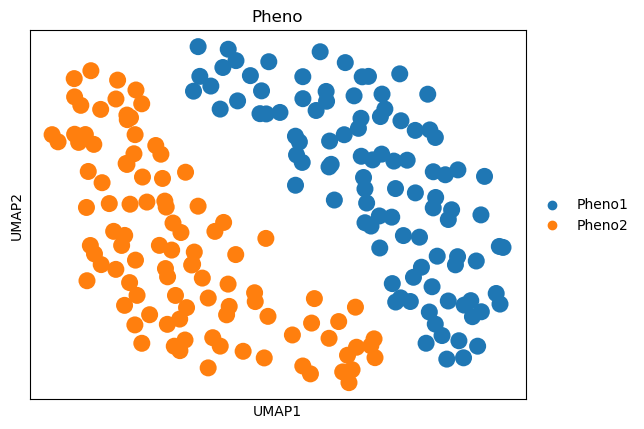

In [11]:
sc.pp.normalize_total(bulk_adata, target_sum=1e4)
sc.pp.log1p(bulk_adata)
sc.pp.scale(bulk_adata)
sc.pp.pca(bulk_adata)
sc.pp.neighbors(bulk_adata)
sc.tl.umap(bulk_adata)
sc.pl.umap(bulk_adata, color='Pheno')


### SCVI

In [3]:
bulk_adata = sc.read_h5ad('../data/Simulation/sim1_bulk.h5ad')

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
from model import ContrastiveAE
from dataset import ContrastiveDataModule
import pytorch_lightning as pl
data_module = ContrastiveDataModule(bulk_adata, label_key='Pheno', normalize=True, log1p=True)

In [326]:
model = ContrastiveAE(input_dim=500, latent_dim=64, hidden_dims=[256, 128], margin=2.0, label_key='Pheno')
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type        | Params | Mode 
-----------------------------------------------------
0 | encoder      | Encoder     | 170 K  | train
1 | decoder      | Decoder     | 170 K  | train
2 | triplet_loss | TripletLoss | 0      | train
3 | recon_loss   | MSELoss     | 0      | train
-----------------------------------------------------
340 K     Trainable params
0         Non-trainable params
340 K     Total params
1.363     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/home/DingchengYi/BulkPheno/scripts/../src/model.py:489: ImplicitModificationWarning: Setting element `.obsm['X_latent']` of view, initializing view as actual.
  if store_in_adata:


In [56]:
train_loader = data_module.train_dataloader()
for batch in train_loader:
    print(batch.keys())
    print(batch['anchor'].shape, batch['positive'].shape, batch['negative'].shape)
    print(batch)
    break


dict_keys(['anchor', 'positive', 'negative', 'label'])
torch.Size([128, 500]) torch.Size([128, 500]) torch.Size([128, 500])
{'anchor': tensor([[ 9.6873, 16.7961, 76.0682,  ...,  1.7569, 29.1414,  8.8375],
        [ 9.6916, 16.7998, 76.0052,  ...,  1.7584, 29.2911,  8.8418],
        [ 9.6652, 16.7662, 76.0557,  ...,  1.7514, 29.1052,  8.8168],
        ...,
        [ 9.6633, 16.7627, 76.0566,  ...,  1.7512, 29.0984,  8.8151],
        [ 9.7411, 16.8672, 75.9764,  ...,  1.7706, 29.0702,  8.8884],
        [ 9.6732, 16.7780, 76.0941,  ...,  1.7533, 29.1214,  8.8243]]), 'positive': tensor([[ 9.7573, 16.8907, 76.1189,  ...,  1.7743, 28.9478,  8.9035],
        [ 9.7444, 16.8722, 76.0227,  ...,  1.7713, 29.2302,  8.8915],
        [ 9.6334, 17.1550, 76.1137,  ...,  1.7438, 29.1996,  8.7869],
        ...,
        [ 9.6836, 16.7906, 76.0148,  ...,  1.7561, 29.1336,  8.8341],
        [ 9.6857, 17.2264, 76.0118,  ...,  1.7568, 29.1338,  8.8362],
        [ 9.6678, 16.7703, 76.1202,  ...,  1.7520, 29.2

In [5]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
model.eval()
z = []
for batch in train_loader:
    x = batch['expression']
    z.append(model.encoder(x).detach().numpy())
for batch in val_loader:
    x = batch['expression']
    z.append(model.encoder(x).detach().numpy())
z = np.concatenate(z)
z = pd.DataFrame(z)
z

KeyError: 'expression'

In [225]:
val_data = data_module.val_data
val_data.obs

,Pheno
39,Pheno1
65,Pheno1
96,Pheno1
149,Pheno2
174,Pheno2
66,Pheno1
80,Pheno1
152,Pheno2
44,Pheno1
178,Pheno2


In [336]:
sc.pp.normalize_total(bulk_adata, target_sum=1e4)
sc.pp.log1p(bulk_adata)
bulk_adata.X

array([[0.84138006, 1.4583626 , 6.6001067 , ..., 0.15267451, 2.529418  ,
        0.7676145 ],
       [0.8452649 , 1.4635994 , 6.5926805 , ..., 0.15364283, 2.5224535 ,
        0.7712743 ],
       [0.84537864, 1.4637527 , 6.59538   , ..., 0.15367122, 2.5358787 ,
        0.7713815 ],
       ...,
       [0.83618754, 1.4513519 , 6.6032376 , ..., 0.15138464, 2.5210044 ,
        0.7627239 ],
       [0.8404802 , 1.4947864 , 6.6036735 , ..., 0.15245062, 2.527962  ,
        0.76676685],
       [0.83577096, 1.450789  , 6.600729  , ..., 0.15128139, 2.5333796 ,
        0.76233166]], dtype=float32)

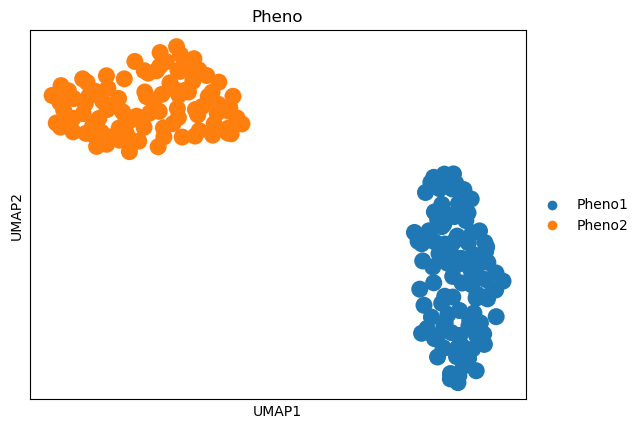

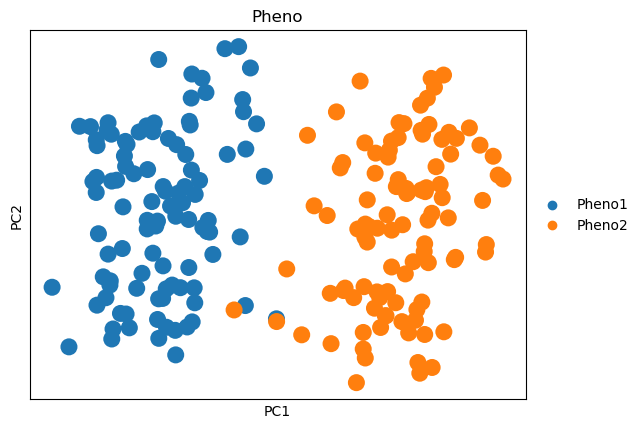

In [337]:
bulk_adata.obsm["X_scVI"] = model.get_latent_embedding(bulk_adata)

sc.pp.neighbors(bulk_adata, use_rep="X_scVI")
sc.tl.umap(bulk_adata)
sc.pp.pca(bulk_adata)
sc.pl.umap(bulk_adata, color='Pheno')
sc.pl.pca(bulk_adata, color='Pheno')

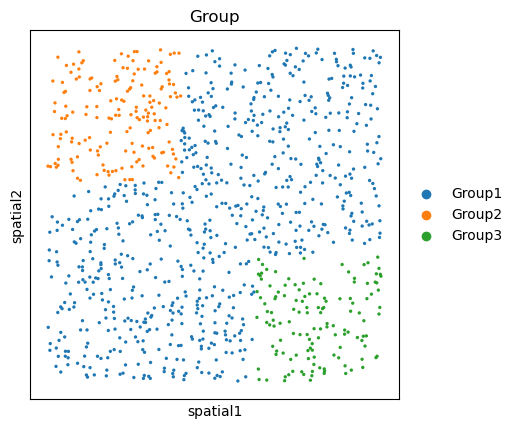

In [382]:
sim1a_adata = sc.read_h5ad('../data/Simulation/sim1_1a.h5ad')
sc.pl.spatial(sim1a_adata, color='Group', spot_size=0.01)

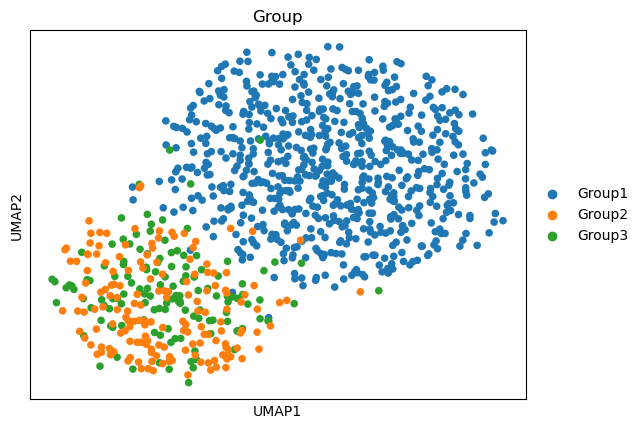

In [185]:
sc.pp.neighbors(sim1a_adata)
sc.tl.umap(sim1a_adata)
sc.pl.umap(sim1a_adata, color='Group')

In [383]:
sc.pp.neighbors(sim1a_adata, n_neighbors=20, use_rep='spatial')
sim1a_adata.obsp['spatial_connectivities'] = (sim1a_adata.obsp['distances'] > 0).astype(int)
sim1a_adata

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    uns: 'Group_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'distances', 'connectivities', 'spatial_connectivities'

In [385]:
sim1a_adata.layers['counts'] = sim1a_adata.X.copy()
sim1a_adata.layers['niche_expression'] = (sim1a_adata.obsp['spatial_connectivities'] @ sim1a_adata.X / 19).astype(int)
sim1a_adata.X = sim1a_adata.layers['niche_expression']

In [386]:
sim1a_adata.layers['counts']

array([[   9,   20, 4613, ...,    2,   69,    7],
       [   8,   19, 4456, ...,    1,   68,   10],
       [   6,   24, 4702, ...,    1,   77,    7],
       ...,
       [   7,   19, 4006, ...,    2,   63,    8],
       [   8,   19, 4051, ...,    1,   67,    8],
       [   8,   17, 4201, ...,    1,   67,    8]])

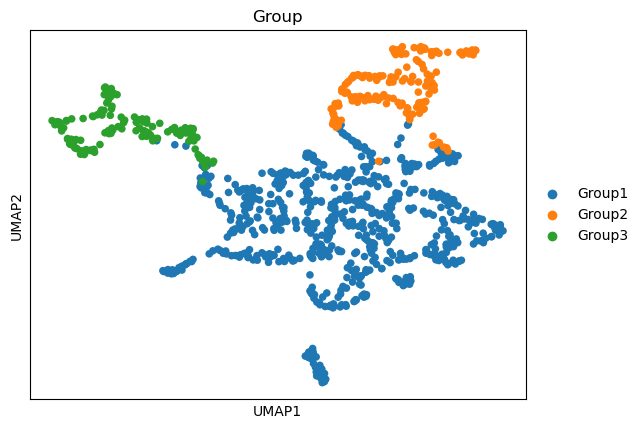

In [387]:
sim1a_adata.obsm['niche_expression'] = sim1a_adata.layers['niche_expression']
sc.pp.neighbors(sim1a_adata, use_rep='niche_expression')
sc.tl.umap(sim1a_adata)
sc.pl.umap(sim1a_adata, color='Group')

In [388]:
total_adata = sc.AnnData(X=np.concatenate([sim1a_adata.X, bulk_adata.X], axis=0), obs=pd.DataFrame({'Pheno': ['Unknown']*sim1a_adata.shape[0] + list(bulk_adata.obs['Pheno']), 'Group': sim1a_adata.obs['Group'].tolist() + list(bulk_adata.obs['Pheno'])}))
total_adata.obs['Pheno'] = total_adata.obs['Pheno'].astype(str)
total_adata.obs['Pheno'].replace({'nan': 'Unknown'}, inplace=True)
total_adata.obs

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_109358/3644891656.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  total_adata.obs['Pheno'].replace({'nan': 'Unknown'}, inplace=True)


,Pheno,Group
0,Unknown,Group1
1,Unknown,Group1
2,Unknown,Group1
3,Unknown,Group1
4,Unknown,Group1
...,...,...
1195,Pheno2,Pheno2
1196,Pheno2,Pheno2
1197,Pheno2,Pheno2
1198,Pheno2,Pheno2


In [333]:
total_adata.X

array([[   9,   20, 4613, ...,    2,   69,    7],
       [   8,   19, 4456, ...,    1,   68,   10],
       [   6,   24, 4702, ...,    1,   77,    7],
       ...,
       [   8,   20, 4506, ...,    1,   70,    7],
       [   8,   21, 4474, ...,    1,   70,    7],
       [   8,   20, 4498, ...,    1,   71,    7]])

In [ ]:
SCANVI.setup_anndata(total_adata, labels_key='Pheno', unlabeled_category='Unknown')
model_anvi = SCANVI.from_scvi_model(model, unlabeled_category='Unknown', labels_key='Pheno', adata=total_adata)
model_anvi.train(max_epochs=40)

total_adata.obsm["X_scanvi"] = model_anvi.get_latent_representation()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Training for 40 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/40 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


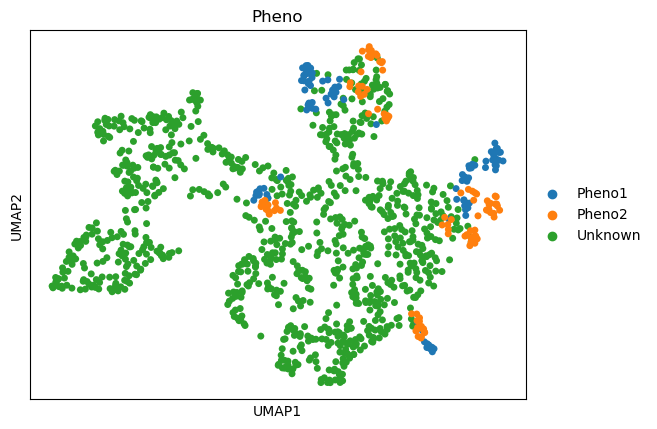

In [72]:
sc.pp.neighbors(total_adata, use_rep="X_scanvi")
sc.tl.umap(total_adata)
sc.pl.umap(total_adata, color='Pheno')

,Pheno
0,Unknown
1,Unknown
2,Unknown
3,Unknown
4,Unknown
...,...
1195,Pheno2
1196,Pheno2
1197,Pheno2
1198,Pheno2


In [389]:
sc.pp.normalize_total(total_adata, target_sum=1e4)
sc.pp.log1p(total_adata)

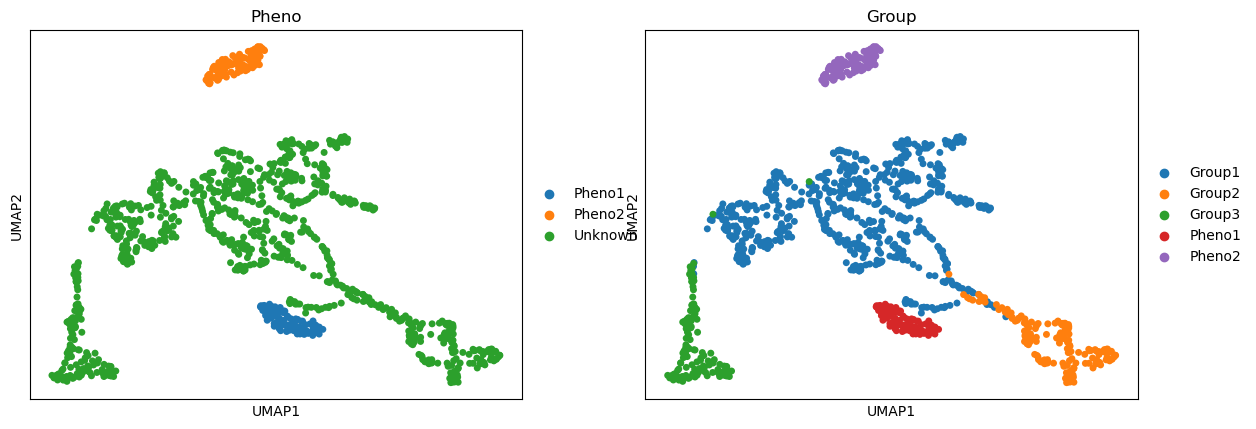

In [390]:
total_adata.obsm['X_con'] = model.get_latent_embedding(total_adata)
sc.pp.neighbors(total_adata, use_rep="X_con", n_neighbors=20)
sc.tl.umap(total_adata)
sc.pl.umap(total_adata, color=['Pheno', 'Group'])

In [297]:
np.median(total_adata[total_adata.obs['Group'] == 'Group3'].obsm['X_umap'], axis=0)

array([ 4.1832128, -2.1285963], dtype=float32)

In [293]:
((total_adata.obsm['X_umap'][:, 0] < 9) & (total_adata.obsm['X_umap'][:, 0] > 7)).sum()

58

<Axes: >

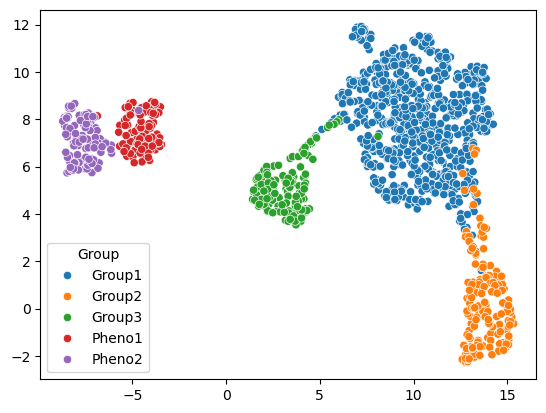

In [303]:
sns.scatterplot(x=total_adata.obsm['X_umap'][:, 0], y=total_adata.obsm['X_umap'][:, 1], hue=total_adata.obs['Group'])

In [318]:
interested_idx = total_adata[(total_adata.obsm['X_umap'][:, 0] < 6) & (total_adata.obsm['X_umap'][:, 1] > 6) & (total_adata.obsm['X_umap'][:, 0] > 4)].obs_names.astype(int)

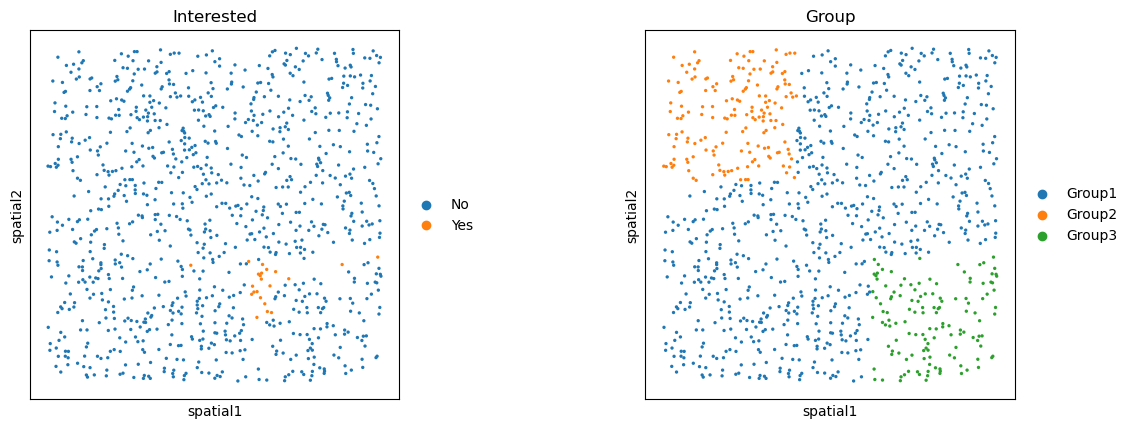

In [323]:
new_idx = sim1a_adata[interested_idx].obs_names
sim1a_adata.obs['Interested'] = 'No'
sim1a_adata.obs.loc[new_idx, 'Interested'] = 'Yes'
sc.pl.spatial(sim1a_adata, color=['Interested', 'Group'], spot_size=0.01)

In [397]:
queried = model.query_similar(total_adata, k = 25)
queried['labels']

[['Pheno1', 'Pheno2', 'Pheno2', 'Pheno1', 'Phen..., ['Pheno1', 'Pheno1', 'Pheno2', 'Pheno1', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno1', 'Pheno1', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno1', 'Pheno1', 'Pheno1', 'Pheno1', 'Phen..., ..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen...]
Length: 1200
Categories (2, object): ['Pheno1', 'Pheno2']

In [345]:
queried

{'indices': array([[ 66,  44,  35, ...,  65,  76, 177],
        [ 73,  87, 179, ..., 115, 164,  66],
        [  9,  78, 114, ...,  50, 143,  97],
        ...,
        [  0,  36, 157, ..., 122, 150,  86],
        [162,  36, 141, ..., 172,  41,  58],
        [ 96, 120,  23, ...,  16,   7,   4]]),
 'distances': array([[0.99591374, 0.9957485 , 0.9957212 , ..., 0.99551713, 0.9955035 ,
         0.9954932 ],
        [0.99703133, 0.99699605, 0.99673367, ..., 0.9965786 , 0.996554  ,
         0.99652416],
        [0.99776745, 0.99775684, 0.9977407 , ..., 0.99759907, 0.9975879 ,
         0.99757254],
        ...,
        [1.        , 0.99981946, 0.9998053 , ..., 0.9997743 , 0.99977344,
         0.99977016],
        [1.        , 0.999825  , 0.9998022 , ..., 0.999722  , 0.99972135,
         0.9997153 ],
        [0.99987626, 0.99986887, 0.9998599 , ..., 0.9997854 , 0.9997824 ,
         0.99977976]], dtype=float32),
 'sample_ids': array([['88', '96', '82', ..., '100', '79', '166'],
        ['77', '97

In [347]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
df = pd.DataFrame(queried['labels'])
distance_df = pd.DataFrame(queried['distances'], columns=['Distance_'+str(i) for i in range(25)])
df['Group'] = total_adata.obs['Group'].values
df['Pheno'] = total_adata.obs['Pheno'].values
df = pd.concat([df, distance_df], axis=1)
df['Pheno2_count'] = df[list(range(25))].apply(lambda x: x.value_counts().iloc[0], axis=1)
df['Pheno3_count'] = df[list(range(25))].apply(lambda x: x.value_counts().iloc[1], axis=1)
df['Predicted'] = df[list(range(25))].apply(lambda x: x.value_counts().idxmax(), axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,Distance_18,Distance_19,Distance_20,Distance_21,Distance_22,Distance_23,Distance_24,Pheno2_count,Pheno3_count,Predicted
0,Pheno1,Pheno2,Pheno2,Pheno1,Pheno1,Pheno2,Pheno2,Pheno1,Pheno2,Pheno1,...,0.993565,0.993564,0.993559,0.993526,0.993523,0.993514,0.993484,17,8,Pheno2
1,Pheno1,Pheno1,Pheno2,Pheno1,Pheno1,Pheno2,Pheno1,Pheno2,Pheno2,Pheno2,...,0.997449,0.997446,0.997433,0.997433,0.997431,0.997423,0.997421,17,8,Pheno2
2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,...,0.995931,0.995927,0.995921,0.995919,0.995916,0.995906,0.995903,18,7,Pheno2
3,Pheno1,Pheno1,Pheno2,Pheno2,Pheno1,Pheno2,Pheno2,Pheno2,Pheno1,Pheno2,...,0.997529,0.997522,0.997518,0.997515,0.997508,0.997505,0.997504,13,12,Pheno1
4,Pheno1,Pheno1,Pheno1,Pheno1,Pheno1,Pheno1,Pheno1,Pheno1,Pheno1,Pheno1,...,0.997684,0.997675,0.997664,0.997648,0.997645,0.997643,0.997643,25,0,Pheno1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,...,0.999695,0.999688,0.999679,0.999678,0.999676,0.999676,0.999674,25,0,Pheno2
1196,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,...,0.999685,0.999681,0.999681,0.999680,0.999674,0.999672,0.999671,25,0,Pheno2
1197,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,...,0.999706,0.999703,0.999699,0.999691,0.999689,0.999676,0.999676,25,0,Pheno2
1198,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,Pheno2,...,0.999674,0.999668,0.999667,0.999661,0.999651,0.999650,0.999650,25,0,Pheno2


In [399]:
def calculate_avg_similarity(row):
    pheno1_sum = 0
    pheno2_sum = 0
    pheno1_count = 0
    pheno2_count = 0

    for i in range(25):
        if row[i] == 'Pheno1':
            pheno1_sum += row[f'Distance_{i}']
            pheno1_count += 1
        elif row[i] == 'Pheno2':
            pheno2_sum += row[f'Distance_{i}']
            pheno2_count += 1

    # 计算平均相似度
    avg_pheno1 = pheno1_sum / pheno1_count if pheno1_count > 0 else 0
    avg_pheno2 = pheno2_sum / pheno2_count if pheno2_count > 0 else 0

    return avg_pheno1, avg_pheno2

# 应用函数到每一行
df[['Avg_Similarity_Pheno1', 'Avg_Similarity_Pheno2']] = df.apply(
    lambda row: pd.Series(calculate_avg_similarity(row)), axis=1
)


In [395]:
pd.concat([sim1a_adata.obs,df.iloc[:1000][['Avg_Similarity_Pheno1', 'Avg_Similarity_Pheno2']]], axis=1)

,Cell,Group,ExpLibSize,sizeFactor,Avg_Similarity_Pheno1,Avg_Similarity_Pheno2
Cell630,Cell630,Group1,58382.309795,0.961584,NaN,NaN
Cell1584,Cell1584,Group1,70427.871672,1.169534,NaN,NaN
Cell1606,Cell1606,Group1,55845.632667,0.906677,NaN,NaN
Cell960,Cell960,Group1,56146.410243,0.922599,NaN,NaN
Cell597,Cell597,Group1,68871.728160,1.130074,NaN,NaN
...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,0.994710,0.0
996,NaN,NaN,NaN,NaN,0.993317,0.0
997,NaN,NaN,NaN,NaN,0.993633,0.0
998,NaN,NaN,NaN,NaN,0.993442,0.0


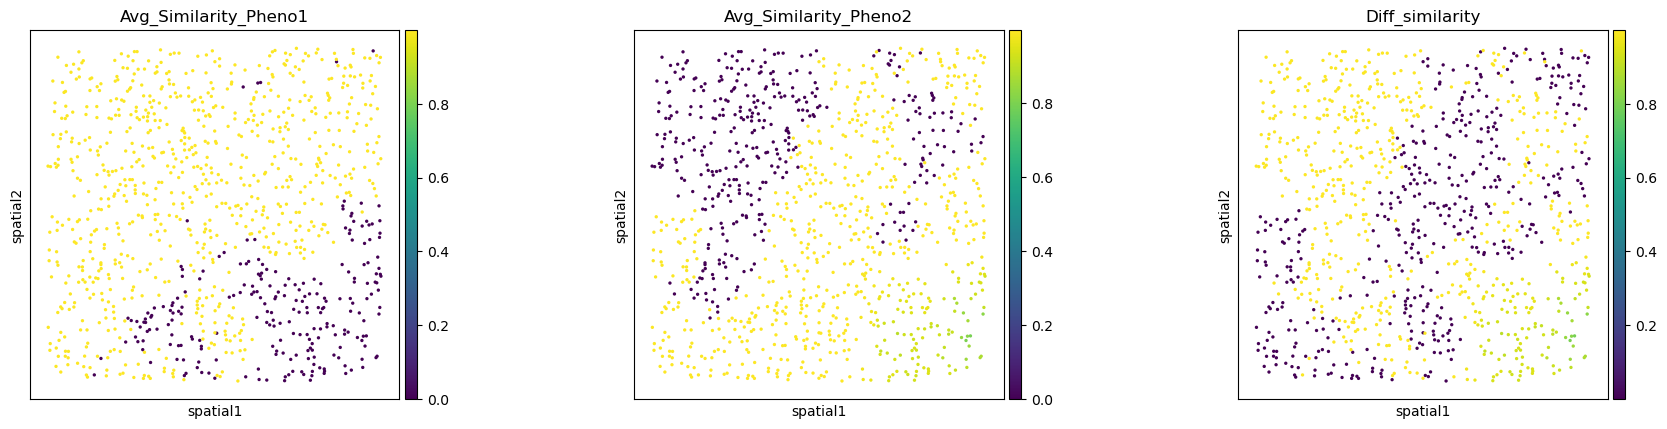

In [402]:
sim1a_adata.obs['Avg_Similarity_Pheno1'] = df.iloc[:1000]['Avg_Similarity_Pheno1'].values
sim1a_adata.obs['Avg_Similarity_Pheno2'] = df.iloc[:1000]['Avg_Similarity_Pheno2'].values
sim1a_adata.obs['Diff_similarity'] = abs(sim1a_adata.obs['Avg_Similarity_Pheno1'] - sim1a_adata.obs['Avg_Similarity_Pheno2'])
sc.pl.spatial(sim1a_adata, color=['Avg_Similarity_Pheno1', 'Avg_Similarity_Pheno2', 'Diff_similarity'], spot_size=0.01)

In [401]:
df.value_counts(['Predicted', 'Group'])

Predicted  Group 
Pheno1     Group1    354
Pheno2     Group1    348
Pheno1     Group2    166
Pheno2     Group3    132
Pheno1     Pheno1    100
Pheno2     Pheno2    100
Name: count, dtype: int64

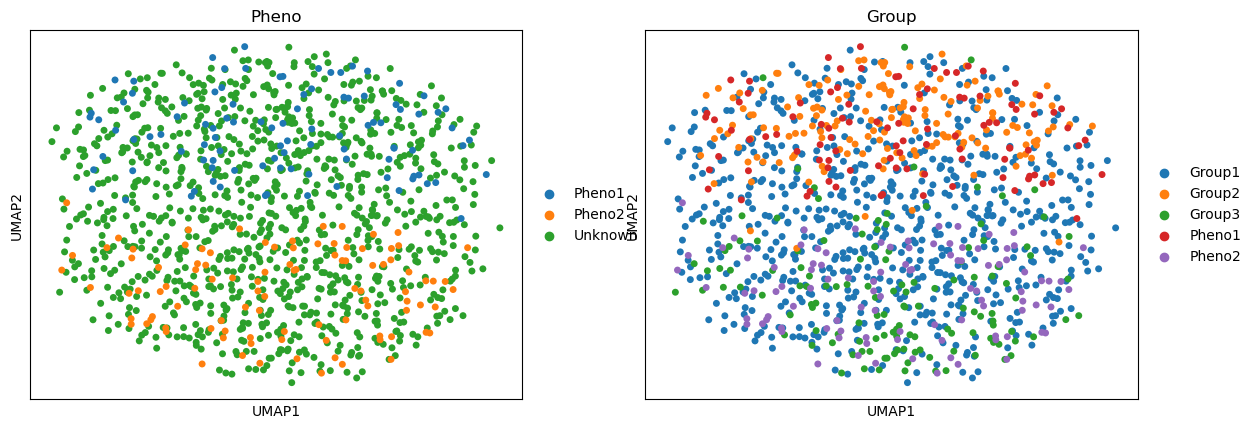

In [374]:
sc.pp.neighbors(total_adata, use_rep="X")
sc.tl.umap(total_adata)
sc.pl.umap(total_adata, color=['Pheno', 'Group'])

### Spatial Niche Embedding

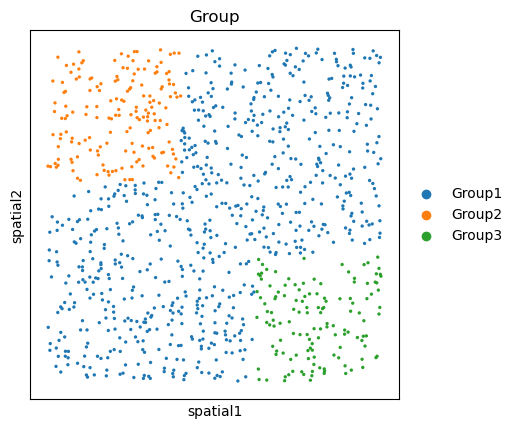

In [52]:
sim1a_adata = sc.read_h5ad('../data/Simulation/sim1_1a.h5ad')
sc.pl.spatial(sim1a_adata, color='Group', spot_size=0.01)

In [53]:
sc.pp.neighbors(sim1a_adata, n_neighbors=20, use_rep='spatial')
import scipy.sparse as sp
sim1a_adata.obsp['spatial_connectivities'] = sp.coo_matrix((sim1a_adata.obsp['distances'] > 0).astype(int))
sim1a_adata.obsp['spatial_distances'] = sim1a_adata.obsp['distances']
sim1a_adata

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    uns: 'Group_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [54]:
from dataset import GraphContrastiveDataModule, SpatialGraphDataset
from torch_geometric.loader import DataLoader
from model import GraphContrastiveModel
graph_dataset = SpatialGraphDataset(sim1a_adata, hops=2)
graph_dataset.len()

/home/DingchengYi/BulkPheno/scripts/../src/dataset.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


1000

In [39]:
graph_dataset[0].edge_index

tensor([[ 0,  0,  0,  ..., 32, 32, 32],
        [ 2,  3,  6,  ..., 28, 30, 31]])

In [55]:
train_idx = np.random.choice(1000, int(graph_dataset.len() * 0.8), replace=False)
val_idx = np.setdiff1d(graph_dataset.indices(), train_idx)
train_dataset = graph_dataset[train_idx]
val_dataset = graph_dataset[val_idx]
print(len(train_dataset), len(val_dataset))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, follow_batch=['x', 'mean_expression'])
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, follow_batch=['x', 'mean_expression'])

800 200


In [63]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="SpatialGCL")

In [69]:
graph_model = GraphContrastiveModel(input_dim=500, recon_weight=0.5)
graph_trainer = pl.Trainer(max_epochs=20, logger=wandb_logger, log_every_n_steps=1)
graph_trainer.fit(graph_model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory ./SpatialGCL/fc534st1/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | conv1   | GATConv    | 129 K  | train
1 | conv2   | GATConv    | 33.4 K | train
2 | decoder | Sequential | 161 K  | train
-----------------------------------------------
324 K     Trainable params
0         Non-trainable params
324 K     Total params
1.297     Total estimated model params size (MB)
12        Modules in train mode
0         

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [70]:
from networkx import center


z_emb = []
center_idxs = []
for batch in train_loader:
    print(batch)
    idxes = batch['center_node_idx']
    center_idxs.append(idxes)
    
    z = graph_model(batch)
    z_emb.append(z.detach().numpy())

for batch in val_loader:
    idxes = batch['center_node_idx']
    center_idxs.append(idxes)
    z = graph_model(batch)
    z_emb.append(z.detach().numpy())
    
    
z_emb = np.concatenate(z_emb, axis=0)
z_emb.shape
idxes = np.concatenate(center_idxs)
idxes.shape

DataBatch(x=[7441, 500], x_batch=[7441], x_ptr=[129], edge_index=[2, 109614], edge_attr=[109614], pos=[7441, 2], center_node_idx=[128], mean_expression=[64000], mean_expression_batch=[64000], mean_expression_ptr=[129], batch=[7441], ptr=[129])
DataBatch(x=[7352, 500], x_batch=[7352], x_ptr=[129], edge_index=[2, 108449], edge_attr=[108449], pos=[7352, 2], center_node_idx=[128], mean_expression=[64000], mean_expression_batch=[64000], mean_expression_ptr=[129], batch=[7352], ptr=[129])
DataBatch(x=[7707, 500], x_batch=[7707], x_ptr=[129], edge_index=[2, 113839], edge_attr=[113839], pos=[7707, 2], center_node_idx=[128], mean_expression=[64000], mean_expression_batch=[64000], mean_expression_ptr=[129], batch=[7707], ptr=[129])
DataBatch(x=[7699, 500], x_batch=[7699], x_ptr=[129], edge_index=[2, 114195], edge_attr=[114195], pos=[7699, 2], center_node_idx=[128], mean_expression=[64000], mean_expression_batch=[64000], mean_expression_ptr=[129], batch=[7699], ptr=[129])
DataBatch(x=[7388, 500],

(1000,)

In [58]:
pd.DataFrame(z_emb, index=idxes).sort_index().values

array([[ -664.6265 ,  -584.14636,  -902.651  , ...,  1536.1476 ,
          350.3124 , -1194.8282 ],
       [ -779.13257,  -600.7061 ,  -846.81976, ...,  1460.8223 ,
          322.54834, -1174.9358 ],
       [ -682.1542 ,  -603.1893 ,  -932.6259 , ...,  1519.5238 ,
          374.748  , -1212.6718 ],
       ...,
       [ -646.7452 ,  -549.93524,  -844.7254 , ...,  1453.8845 ,
          259.35068, -1160.3026 ],
       [ -611.44617,  -540.78156,  -897.22485, ...,  1486.4739 ,
          331.1626 , -1142.2717 ],
       [ -599.8408 ,  -541.6354 ,  -900.9342 , ...,  1503.3218 ,
          360.69604, -1118.687  ]], dtype=float32)

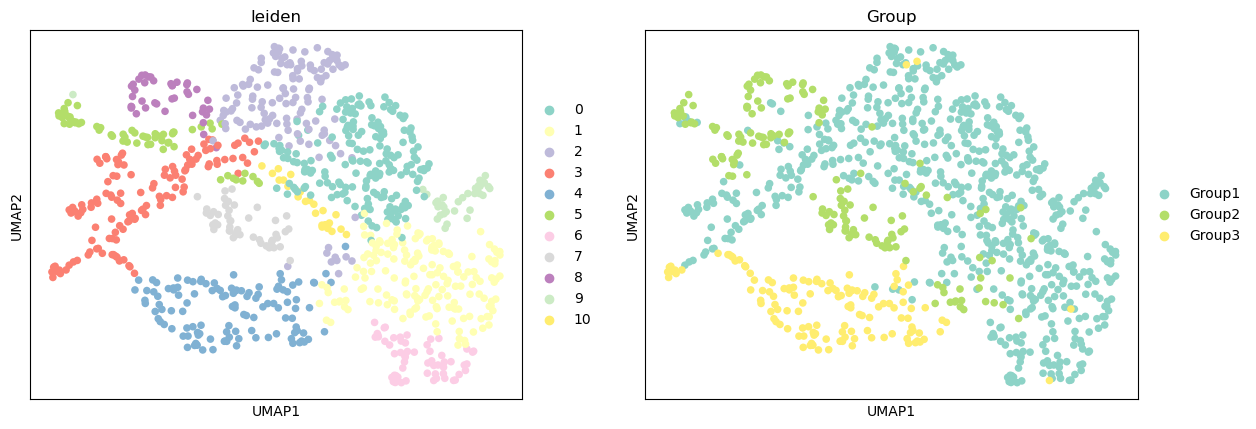

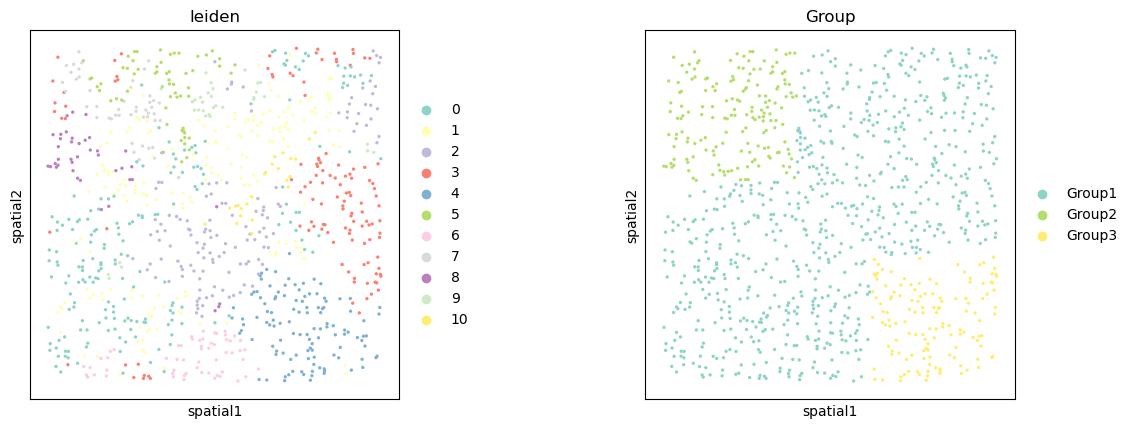

In [72]:
sim1a_adata.obsm['X_graph'] = pd.DataFrame(z_emb, index=idxes).sort_index().values
sc.pp.neighbors(sim1a_adata, use_rep='X_graph')
sc.tl.leiden(sim1a_adata, resolution=0.5)
sc.tl.umap(sim1a_adata)
sc.pl.umap(sim1a_adata, color=['leiden', 'Group'], palette='Set3')
sc.pl.spatial(sim1a_adata, color=['leiden', 'Group'], spot_size=0.01, palette='Set3')